In [1]:
from pathlib import Path
from typing import Literal

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RectBivariateSpline

# Params

In [2]:
c_function_type: Literal["spline", "synth"] = "spline"

isotherm_type = "freundlich"
t_idx_start = 0
Nt = 251
T_MAX = 10000

# Data Loading

In [3]:
base_dir = Path("../data_out_github_c/default_finn")
u_ret = np.load(base_dir / "u_ret.npy")
ret_freundlich = np.load(base_dir / f"retardation_{isotherm_type}.npy")

c_train = np.load(
    Path(f"../data/synthetic_data/retardation_{isotherm_type}/c_train.npy")
)[t_idx_start:Nt, 0, :]
assert c_train.shape[0] == Nt - t_idx_start

Nx = c_train.shape[1]
x = np.linspace(0, 1, Nx)
t = np.linspace(0, 1, Nt)[t_idx_start:]
assert t.shape[0] == c_train.shape[0]
assert x.shape[0] == c_train.shape[1]

In [6]:
u_ret[:].shape

(100, 1)

# Field Functions

In [319]:
# Create a B-spline surrogate model for c(x,t)
spline = RectBivariateSpline(t, x, c_train)
spline(t, x).shape

(251, 26)

In [320]:
def f(t, x):
    if c_function_type == "spline":
        return spline(t, x)

    T, X = np.meshgrid(t, x, indexing="ij")
    return np.sin(np.pi * X) * np.exp(-T / 5000)


def dfdt(t, x):
    if c_function_type == "spline":
        return spline(t, x, dx=1)

    T, X = np.meshgrid(t, x, indexing="ij")
    return -1 / 5000 * np.sin(np.pi * X) * np.exp(-T / 5000)


def dfdx(t, x):
    if c_function_type == "spline":
        return spline(t, x, dy=1)

    T, X = np.meshgrid(t, x, indexing="ij")
    return np.pi * np.cos(np.pi * X) * np.exp(-T / 5000)


def d2fdx2(t, x):
    if c_function_type == "spline":
        return spline(t, x, dy=2)

    T, X = np.meshgrid(t, x, indexing="ij")
    return -(np.pi**2) * np.sin(np.pi * X) * np.exp(-T / 5000)

## All C Fields

In [321]:
c = f(t, x)
dcdt = dfdt(t, x)
dcdx = dfdx(t, x)
d2cdx2 = d2fdx2(t, x)

print(c_train.min(), c_train.max())
print(c.min(), c.max())
print(dcdt.min(), dcdt.max())
print(dcdx.min(), dcdx.max())
print(d2cdx2.min(), d2cdx2.max())

-3.0221627515326604e-45 0.9457106817381344
-6.726451462240286e-19 0.9457106817381343
-1.2102058270319307 92.30217958026273
-11.630247234026648 0.007192144519138439
-9.719356631542446 253.62620218348778


## Histograms

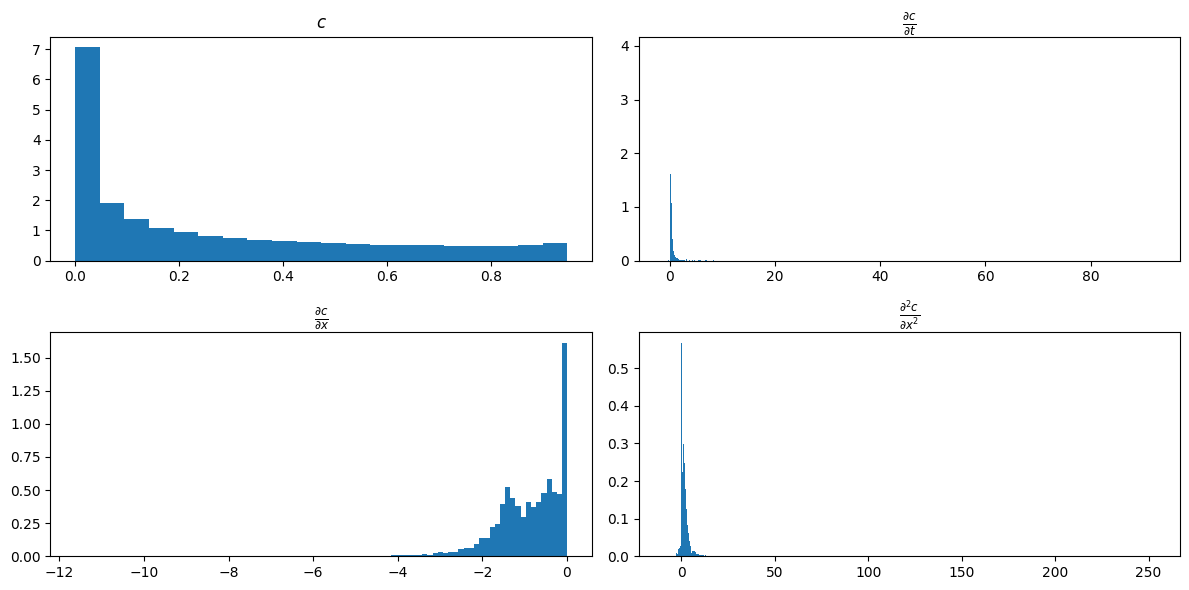

In [322]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))

axs[0, 0].hist(c.flat, bins="auto", density=True)
axs[0, 1].hist(dcdt.flat, bins="auto", density=True)
axs[1, 0].hist(dcdx.flat, bins="auto", density=True)
axs[1, 1].hist(d2cdx2.flat, bins="auto", density=True)

axs[0, 0].set_title(r"$c$")
axs[0, 1].set_title(r"$\frac{\partial c}{\partial t}$")
axs[1, 0].set_title(r"$\frac{\partial c}{\partial x}$")
axs[1, 1].set_title(r"$\frac{\partial^2 c}{\partial x^2}$")

plt.tight_layout()
plt.show()

## Mesh Plots

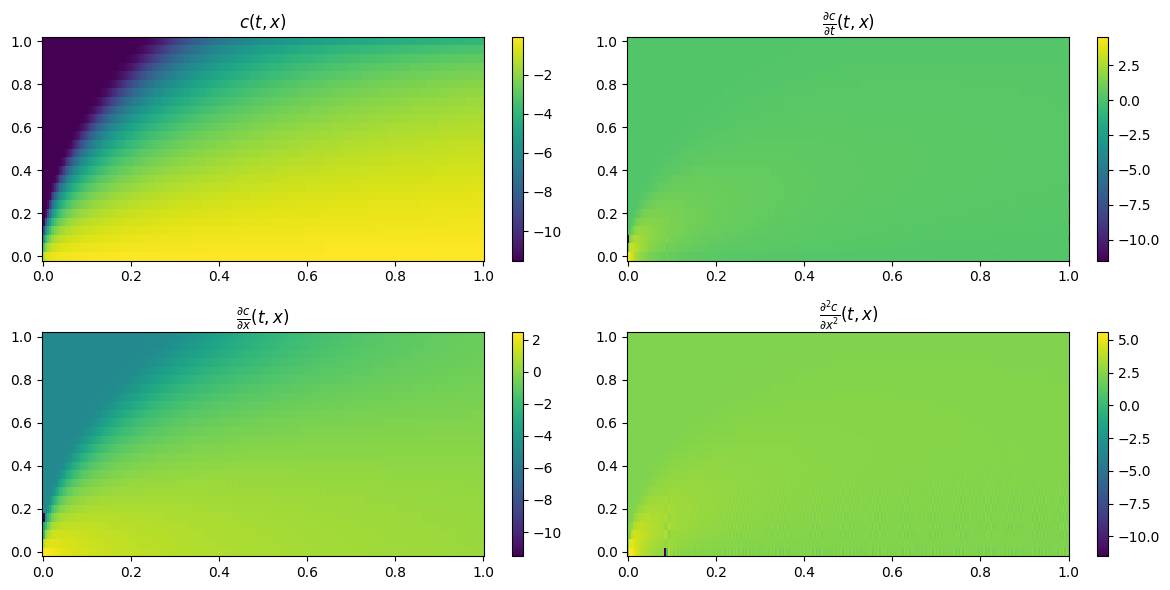

In [323]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))


def transform(field):
    # return field
    return np.log(field - field.min() + 1e-5)


mesh_kwargs = dict()

plt.colorbar(axs[0, 0].pcolormesh(t, x, transform(c.T), **mesh_kwargs))
# axs[0, 0].contour(t, x, transform(c.T), colors="black")
plt.colorbar(axs[0, 1].pcolormesh(t, x, transform(dcdt.T), **mesh_kwargs))
plt.colorbar(axs[1, 0].pcolormesh(t, x, transform(-dcdx.T), **mesh_kwargs))
plt.colorbar(axs[1, 1].pcolormesh(t, x, transform(d2cdx2.T), **mesh_kwargs))

axs[0, 0].set_title(r"$c(t,x)$")
axs[0, 1].set_title(r"$\frac{\partial c}{\partial t}(t,x)$")
axs[1, 0].set_title(r"$\frac{\partial c}{\partial x}(t,x)$")
axs[1, 1].set_title(r"$\frac{\partial^2 c}{\partial x^2}(t,x)$")

plt.tight_layout()
plt.show()

## Spline Error

MSE: 6.16e-33, MAE: 5.55e-16


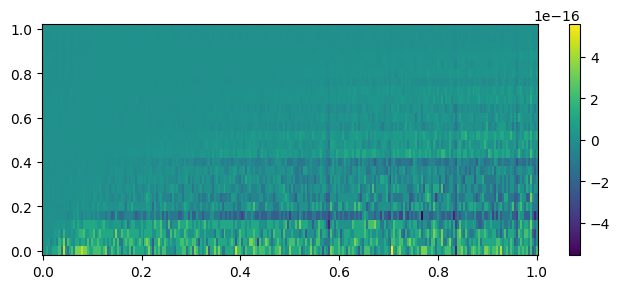

In [324]:
if c_function_type == "spline":  # spline error
    spline_err = c - c_train
    print(
        f"MSE: {np.square(spline_err).mean():.2e}, MAE: {np.abs(spline_err).max():.2e}"
    )
    fig, ax = plt.subplots(figsize=(8, 3))
    plt.colorbar(ax.pcolormesh(t, x, spline_err.T))
    plt.show()

## 1D Curves (e.g BTC)

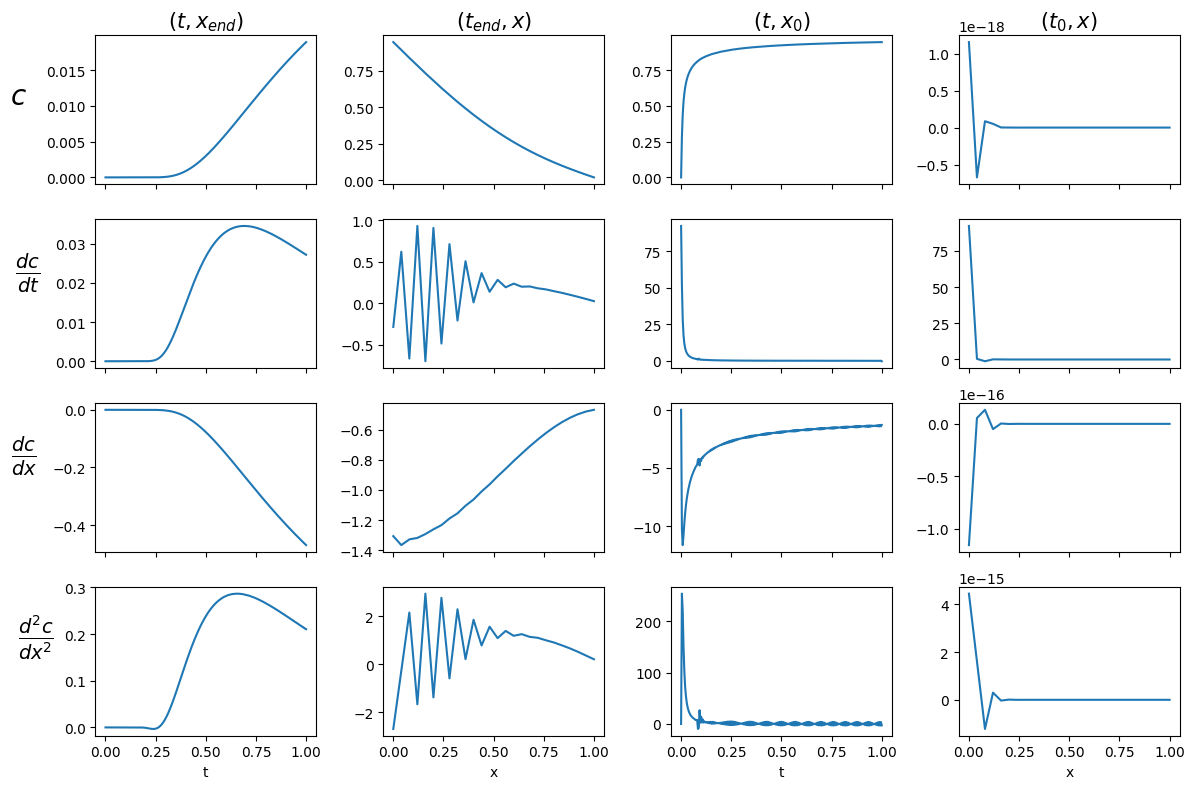

In [325]:
nrows = 4
ncols = 4
fig, axs = plt.subplots(
    nrows=nrows, ncols=ncols, figsize=(3 * ncols, 2 * nrows), sharex="col"
)  # , sharey="row")

axs[0, 0].set_title(r"$(t, x_{end})$", size=15)
axs[0, 1].set_title(r"$(t_{end}, x)$", size=15)
axs[0, 2].set_title(r"$(t, x_0)$", size=15)
axs[0, 3].set_title(r"$(t_0, x)$", size=15)
# for k, i in enumerate(range(0, 5 * 4, 4)):
for k, i in enumerate(range(1)):
    axs[0, 0].plot(t, c[:, -(i + 1)], color=f"C{k}")
    axs[1, 0].plot(t, dcdt[:, -(i + 1)], color=f"C{k}")
    axs[2, 0].plot(t, dcdx[:, -(i + 1)], color=f"C{k}")
    axs[3, 0].plot(t, d2cdx2[:, -(i + 1)], color=f"C{k}")

    axs[0, 1].plot(x, c[-(i + 1), :], color=f"C{k}")
    axs[1, 1].plot(x, dcdt[-(i + 1), :], color=f"C{k}")
    axs[2, 1].plot(x, dcdx[-(i + 1), :], color=f"C{k}")
    axs[3, 1].plot(x, d2cdx2[-(i + 1), :], color=f"C{k}")

    axs[0, 2].plot(t, c[:, i], color=f"C{k}")
    axs[1, 2].plot(t, dcdt[:, i], color=f"C{k}")
    axs[2, 2].plot(t, dcdx[:, i], color=f"C{k}")
    axs[3, 2].plot(t, d2cdx2[:, i], color=f"C{k}")

    axs[0, 3].plot(x, c[i, :], color=f"C{k}")
    axs[1, 3].plot(x, dcdt[i, :], color=f"C{k}")
    axs[2, 3].plot(x, dcdx[i, :], color=f"C{k}")
    axs[3, 3].plot(x, d2cdx2[i, :], color=f"C{k}")

ylabel_kwargs = dict(rotation=0, size=20, labelpad=20)
axs[0, 0].set_ylabel(r"$c$", **ylabel_kwargs)
axs[1, 0].set_ylabel(r"$\frac{d c}{d t}$", **ylabel_kwargs)
axs[2, 0].set_ylabel(r"$\frac{d c}{d x}$", **ylabel_kwargs)
axs[3, 0].set_ylabel(r"$\frac{d^2 c}{d x^2}$", **ylabel_kwargs)

axs[-1, 0].set_xlabel("t")
axs[-1, 1].set_xlabel("x")
axs[-1, 2].set_xlabel("t")
axs[-1, 3].set_xlabel("x")

plt.tight_layout()
plt.show()

# Retardation

In [326]:
# Compute R(c(x,t)) = d²c/dx² / dc/dt
R_field = d2cdx2 / dcdt
print(R_field.min(), R_field.max(), R_field.shape, c.shape, dcdt.shape)

-14517548992434.734 320010252710559.06 (251, 26) (251, 26) (251, 26)


## Fields

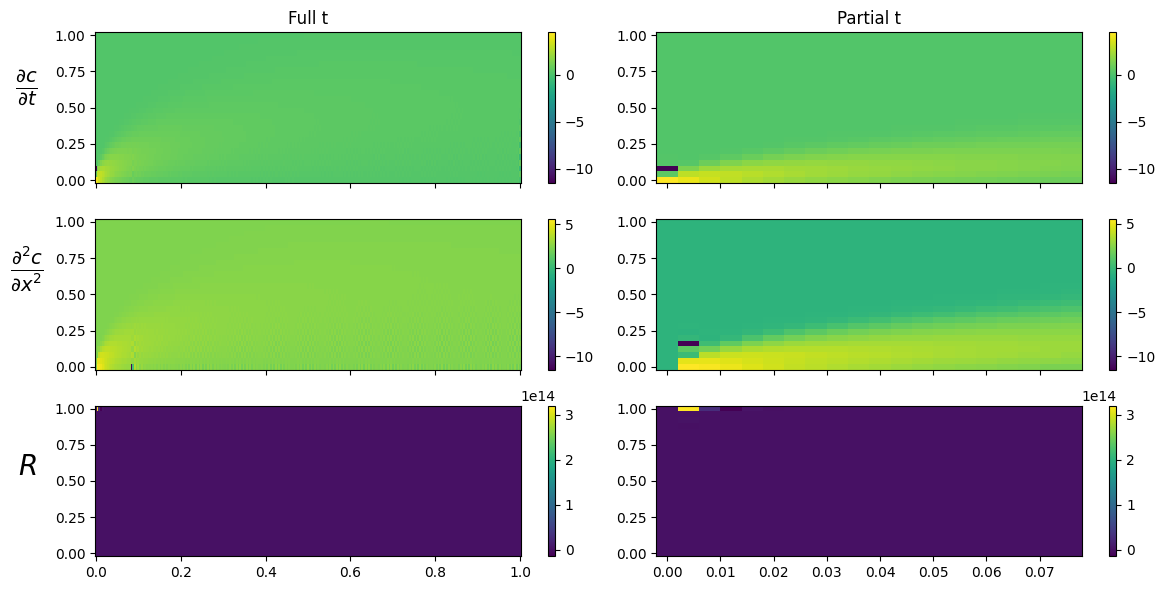

In [327]:
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(12, 6), sharex="col")

plt.colorbar(axs[0, 0].pcolormesh(t, x, transform(dcdt).T))
plt.colorbar(axs[1, 0].pcolormesh(t, x, transform(d2cdx2).T))
plt.colorbar(axs[2, 0].pcolormesh(t, x, R_field.T))

t_idx = 20
plt.colorbar(axs[0, 1].pcolormesh(t[:t_idx], x, transform(dcdt[:t_idx]).T))
plt.colorbar(axs[1, 1].pcolormesh(t[:t_idx], x, transform(d2cdx2[:t_idx]).T))
plt.colorbar(axs[2, 1].pcolormesh(t[:t_idx], x, R_field[:t_idx].T))

axs[0, 0].set_title("Full t")
axs[0, 1].set_title("Partial t")

axs[0, 0].set_ylabel(r"$\frac{\partial c}{\partial t}$", **ylabel_kwargs)
axs[1, 0].set_ylabel(r"$\frac{\partial^2 c}{\partial x^2}$", **ylabel_kwargs)
axs[2, 0].set_ylabel(r"$R$", **ylabel_kwargs)

plt.tight_layout()
plt.show()

## Histograms

-51.511751523277695 36.90123484450744


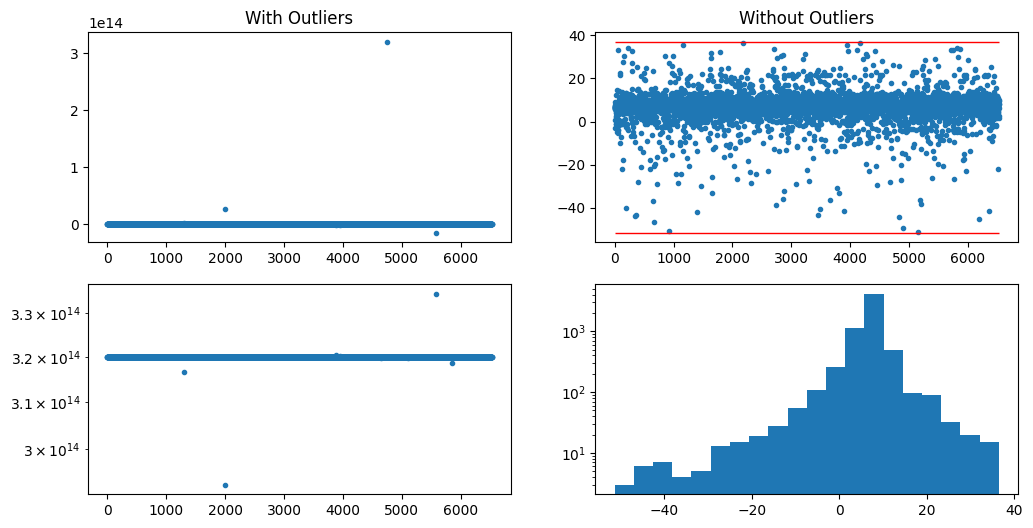

In [328]:
R_field_without_outliers = R_field.copy()
# R_field_without_outliers[R_field < -25000] = np.mean(R_field)

alpha = 1 - 0.975
q_up = np.quantile(R_field, 1 - alpha)
q_down = np.quantile(R_field, alpha)
assert q_down < q_up, (q_down, q_up)

R_field_without_outliers[R_field < q_down] = np.median(R_field)
R_field_without_outliers[R_field > q_up] = np.median(R_field)

print(q_down, q_up)

# ------

x_rand = np.arange(R_field.size)
np.random.shuffle(x_rand)

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))
axs[0, 0].set_title("With Outliers")
axs[0, 1].set_title("Without Outliers")

axs[0, 0].plot(x_rand, R_field.flat, ".")

axs[0, 1].plot(x_rand, R_field_without_outliers.flat, ".")
axs[0, 1].hlines([q_up, q_down], 0, R_field.size, lw=1, color="red")

axs[1, 0].semilogy(x_rand, -(R_field - R_field.max()).ravel(), ".")

axs[1, 1].hist(R_field_without_outliers.flat, bins=20)
axs[1, 1].set_yscale("log")

plt.show()

## R(c) Map

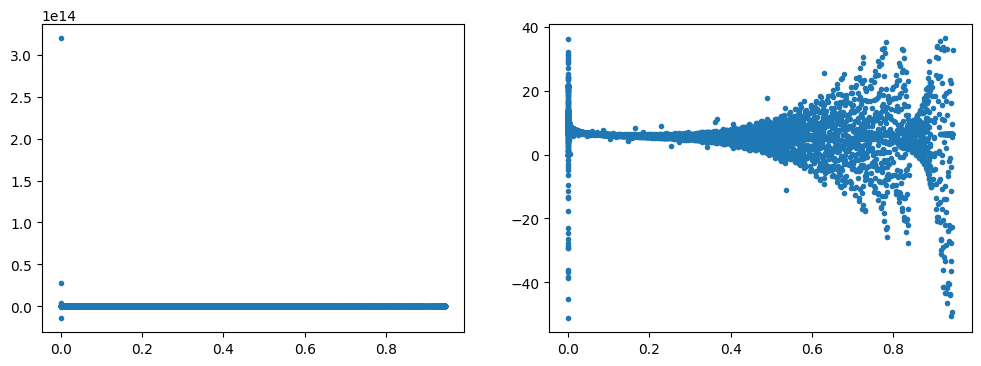

In [330]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
axs[0].plot(c.flat, R_field.flat, ".")
axs[1].plot(c.flat, R_field_without_outliers.flat, ".")
plt.show()

# All Isotherms

In [332]:
def compute_derivatives(t, x, c_field):
    spline = RectBivariateSpline(t, x, c_field)
    return spline(t, x, dx=1), spline(t, x, dy=2)


def ret_from_c_field(t, x, c_field):
    dcdt, d2cdx2 = compute_derivatives(t, x, c_field)
    R_field = d2cdx2 / dcdt

    R_field_without_outliers = R_field.copy()

    alpha = 1 - 0.975
    q_up = np.quantile(R_field, 1 - alpha)
    q_down = np.quantile(R_field, alpha)
    assert q_down < q_up, (q_down, q_up)

    R_field_without_outliers[R_field < q_down] = np.median(R_field)
    R_field_without_outliers[R_field > q_up] = np.median(R_field)

    c_flat = c_field.flatten()
    R_flat = R_field_without_outliers.flatten()
    sort_indices = np.argsort(c_flat)

    return c_flat[sort_indices], R_flat[sort_indices]

In [393]:
def binned_means(x, y, n):
    bins = np.linspace(x.min(), x.max(), n)

    # Find which bin each x value falls into
    bin_indices = np.digitize(x, bins=bins)

    # Initialize an array to store the mean y value for each bin
    mean_y_per_bin = np.array(
        [
            y[bin_indices == i].mean() if np.any(bin_indices == i) else np.nan
            for i in range(1, n)
        ]
    )

    bin_centers = (bins[1:] + bins[:-1]) / 2
    return bin_centers, mean_y_per_bin


def optimal_scaling_factor(a, b):
    # Compute dot products
    numerator = np.dot(a, b)
    denominator = np.dot(a, a)
    
    # Compute the optimal scaling factor
    s = numerator / denominator
    
    return s

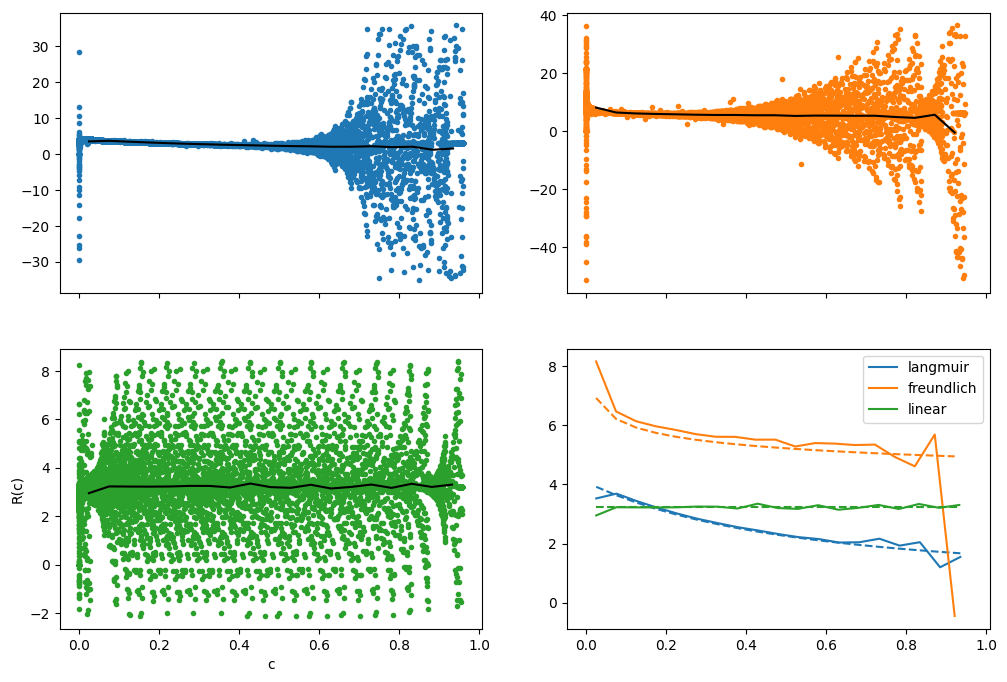

In [397]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), sharey=False, sharex=True)


isotherms = ["langmuir", "freundlich", "linear"]
for col, (ax, isotherm) in enumerate(zip(axs.flat, isotherms)):
    c = np.load(Path(f"../data/synthetic_data/retardation_{isotherm}/c_train.npy"))[
        t_idx_start:Nt, 0, :
    ]

    t = np.linspace(0, 1, c.shape[0])
    x = np.linspace(0, 1, c.shape[1])

    c_vals, ret = ret_from_c_field(t, x, c_field=c)

    bins, mean = binned_means(c_vals, ret, 20)
    ax.plot(c_vals, ret, ".", color=f"C{col}")
    ax.plot(bins, mean, "k-")
    axs.flat[-1].plot(bins, mean, color=f"C{col}", label=isotherm)

    ret_isotherm = np.load(base_dir / f"retardation_{isotherm}.npy").flatten()
    ret_isotherm_interp = np.interp(bins, np.linspace(0,1,100), ret_isotherm)

    s = optimal_scaling_factor(ret_isotherm_interp, mean)
    # print(f"Diffusion coefficient of {isotherm}: {s:.2f}")  # TODO: or 1/s

    axs.flat[-1].plot(bins, s*ret_isotherm_interp, "--", color=f"C{col}")

ax.set_xlabel("c")
ax.set_ylabel("R(c)")
axs.flat[-1].legend()
plt.show()

-----------